# [딥러닝 기본] RNN과 CNN을 이용한 텍스트 분류

## 13-05 사전 훈련된 임베딩을 이용한 성능 상승 시키기

코랩 GPU환경에서 돌림

##### 1. 데이터 로드 및 단어 토큰화

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import torch
import urllib.request
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!ls "/content/drive/MyDrive/Colab Notebooks"

 13_05_사전임베딩모델.ipynb  '26-1 스터디 mnist.ipynb'	'IMDB Dataset.csv'


In [10]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv"
df = pd.read_csv(DATA_PATH)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [12]:
print('결측값 여부 :',df.isnull().values.any())

결측값 여부 : False


<Axes: xlabel='sentiment'>

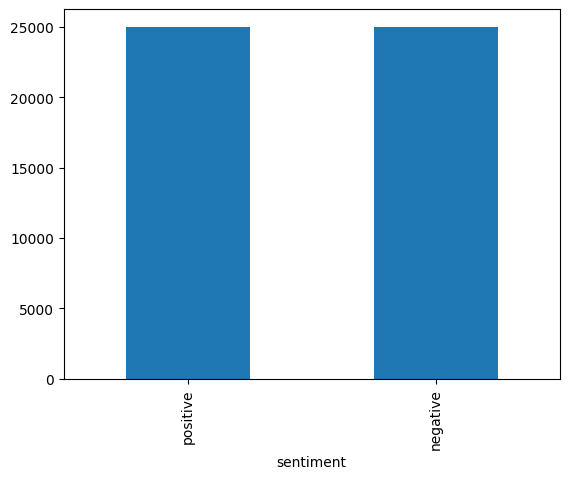

In [13]:
df['sentiment'].value_counts().plot(kind='bar')

In [14]:
print('레이블 개수')
print(df.groupby('sentiment').size().reset_index(name='count'))

레이블 개수
  sentiment  count
0  negative  25000
1  positive  25000


In [15]:
df['sentiment'] = df['sentiment'].replace(['positive','negative'],[1, 0])
df.head()

/tmp/ipython-input-2986343606.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace(['positive','negative'],[1, 0])


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [16]:
X_data = df['review']
y_data = df['sentiment']
print('영화 리뷰의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

영화 리뷰의 개수: 50000
레이블의 개수: 50000


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=0, stratify=y_data)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=0, stratify=y_train)

print('--------훈련 데이터의 비율-----------')
print(f'부정 리뷰 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(y_valid.value_counts()[0]/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(y_valid.value_counts()[1]/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------훈련 데이터의 비율-----------
부정 리뷰 = 50.0%
긍정 리뷰 = 50.0%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.0%
긍정 리뷰 = 50.0%
--------테스트 데이터의 비율-----------
부정 리뷰 = 50.0%
긍정 리뷰 = 50.0%


In [18]:
nltk.download('punkt_tab')
def tokenize(sentences):
  tokenized_sentences = []
  for sent in tqdm(sentences):
    tokenized_sent = word_tokenize(sent)
    tokenized_sent = [word.lower() for word in tokenized_sent]
    tokenized_sentences.append(tokenized_sent)
  return tokenized_sentences

tokenized_X_train = tokenize(X_train)
tokenized_X_valid = tokenize(X_valid)
tokenized_X_test = tokenize(X_test)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
100%|██████████| 25000/25000 [00:29<00:00, 855.31it/s]


In [19]:
# 상위 샘플 2개 출력
for sent in tokenized_X_train[:2]:
  print(sent)

['have', 'you', 'ever', ',', 'or', 'do', 'you', 'have', ',', 'a', 'pet', 'who', "'s", 'been', 'with', 'you', 'through', 'thick', 'and', 'thin', ',', 'who', 'you', "'d", 'be', 'lost', 'without', ',', 'and', 'who', 'you', 'love', 'no', 'matter', 'what', '?', 'betcha', 'never', 'thought', 'they', 'feel', 'the', 'same', 'way', 'about', 'you', '!', '<', 'br', '/', '>', '<', 'br', '/', '>', 'wonderful', ',', 'wonderful', 'family', 'film', '.', 'if', 'you', 'have', 'a', 'soft', 'spot', 'for', 'animals', ',', 'this', 'is', 'guaranteed', 'to', 'make', 'you', 'cry', 'no', 'matter', 'your', 'age', '.', 'i', 'used', 'to', 'watch', 'this', 'movie', 'all', 'the', 'time', 'when', 'i', 'was', 'a', 'little', 'kid', ',', 'and', 'i', 'find', 'that', 'now', ',', 'at', 'age', 'sixteen', ',', 'i', 'love', 'it', 'as', 'much', 'as', 'i', 'did', 'then', '.', 'i', 'could', 'never', 'decide', 'on', 'a', 'favorite', 'character', 'then', ',', 'and', 'i', 'still', 'do', "n't", 'think', 'i', 'can', '!', 'i', 'love',

##### 2. Vocab 만들기

In [20]:
word_list = []
for sent in tokenized_X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 100584


In [21]:
print('훈련 데이터에서의 단어 the의 등장 횟수 :', word_counts['the'])
print('훈련 데이터에서의 단어 love의 등장 횟수 :', word_counts['love'])

훈련 데이터에서의 단어 the의 등장 횟수 : 265697
훈련 데이터에서의 단어 love의 등장 횟수 : 4984


In [22]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])
print(len(vocab))

등장 빈도수 상위 10개 단어
['the', ',', '.', 'a', 'and', 'of', 'to', 'is', '/', '>']
100584


In [23]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", round((rare_cnt / total_cnt)*100,3))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", round((rare_freq / total_freq)*100,3))

단어 집합(vocabulary)의 크기 : 100584
등장 빈도가 2번 이하인 희귀 단어의 수: 61875
단어 집합에서 희귀 단어의 비율: 61.516
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.329


In [24]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 38709


In [25]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 38711


##### 3. 정수 인코딩

In [26]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

encoded_X_train = texts_to_sequences(tokenized_X_train, word_to_index)
encoded_X_valid = texts_to_sequences(tokenized_X_valid, word_to_index)
encoded_X_test = texts_to_sequences(tokenized_X_test, word_to_index)

In [27]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[38, 29, 140, 3, 52, 54, 29, 38, 3, 5, 3406, 47, 19, 95, 22, 29, 161, 4059, 6, 1741, 3, 47, 29, 293, 39, 469, 218, 3, 6, 47, 29, 134, 71, 532, 61, 59, 25184, 130, 214, 44, 249, 2, 189, 114, 58, 29, 41, 12, 13, 10, 11, 12, 13, 10, 11, 384, 3, 384, 253, 26, 4, 57, 29, 38, 5, 2280, 1587, 23, 1477, 3, 17, 9, 5775, 8, 111, 29, 1440, 71, 532, 141, 677, 4, 16, 343, 8, 126, 17, 24, 43, 2, 75, 63, 16, 20, 5, 137, 538, 3, 6, 16, 172, 18, 164, 3, 42, 677, 12075, 3, 16, 134, 14, 21, 89, 21, 16, 83, 110, 4, 16, 94, 130, 1124, 30, 5, 494, 121, 110, 3, 6, 16, 145, 54, 31, 120, 16, 73, 41, 16, 134, 43, 301, 7, 2, 1477, 4, 2, 425, 204, 66, 168, 6, 3964, 3, 50, 5, 1961, 3, 25, 19699, 253, 4, 16, 54, 134, 580, 3, 6, 105, 42, 2, 152, 36, 544, 18, 36, 55, 5, 253, 42, 247, 4, 933, 3, 421, 3, 25, 40, 227, 407, 18, 17, 9, 965, 8, 39, 5, 253, 26, 3, 6, 14, 17326, 18, 233, 872, 4, 8000, 55, 53, 2, 416, 4967, 7, 33, 1, 32, 6, 2669, 9, 2, 416, 1, 2144, 8, 2, 208, 3, 8988, 13008, 12, 13, 10, 11, 12, 13, 10, 11, 2,

In [28]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', tokenized_X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['have', 'you', 'ever', ',', 'or', 'do', 'you', 'have', ',', 'a', 'pet', 'who', "'s", 'been', 'with', 'you', 'through', 'thick', 'and', 'thin', ',', 'who', 'you', "'d", 'be', 'lost', 'without', ',', 'and', 'who', 'you', 'love', 'no', 'matter', 'what', '?', 'betcha', 'never', 'thought', 'they', 'feel', 'the', 'same', 'way', 'about', 'you', '!', '<', 'br', '/', '>', '<', 'br', '/', '>', 'wonderful', ',', 'wonderful', 'family', 'film', '.', 'if', 'you', 'have', 'a', 'soft', 'spot', 'for', 'animals', ',', 'this', 'is', 'guaranteed', 'to', 'make', 'you', 'cry', 'no', 'matter', 'your', 'age', '.', 'i', 'used', 'to', 'watch', 'this', 'movie', 'all', 'the', 'time', 'when', 'i', 'was', 'a', 'little', 'kid', ',', 'and', 'i', 'find', 'that', 'now', ',', 'at', 'age', 'sixteen', ',', 'i', 'love', 'it', 'as', 'much', 'as', 'i', 'did', 'then', '.', 'i', 'could', 'never', 'decide', 'on', 'a', 'favorite', 'character', 'then', ',', 'and', 'i', 'still', 'do', "n't", 'think', 'i', 'can', '!',

##### 4. 패딩

리뷰의 최대 길이 : 2818
리뷰의 평균 길이 : 279.196


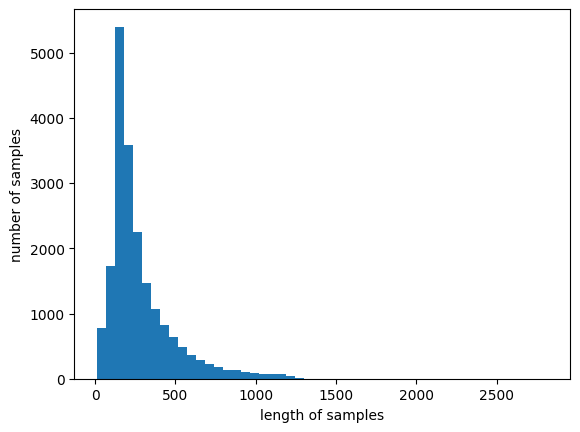

In [29]:
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [31]:
max_len = 500
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 500 이하인 샘플의 비율: 87.795


In [32]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (20000, 500)
검증 데이터의 크기 : (5000, 500)
테스트 데이터의 크기 : (25000, 500)


##### 5. 사전 훈련된 임베딩

In [33]:
!pip install gensim
!pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 59.2 MB/s eta 0:00:00


In [34]:
import gensim

In [35]:
!gdown https://drive.google.com/uc?id=1Av37IVBQAAntSe1X3MOAl5gvowQzd2_j

Downloading...
From (original): https://drive.google.com/uc?id=1Av37IVBQAAntSe1X3MOAl5gvowQzd2_j
From (redirected): https://drive.google.com/uc?id=1Av37IVBQAAntSe1X3MOAl5gvowQzd2_j&confirm=t&uuid=b757e9b4-b030-4f0f-9b63-69d7dc005b31
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:27<00:00, 59.5MB/s]


In [36]:
# 구글의 사전 훈련된 Word2vec 모델을 로드
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [37]:
# 구글의 사전 훈련된 임베딩은 학습되었을 당시 각 단어가 300차원으로 학습된 상태
# 그러므로 우리가 만든 vocab_size만큼의 행을 가지고, 300차원의 열을 가지는 행렬을 만들어 줘야 함
embedding_matrix = np.zeros((vocab_size, 300))

In [38]:
# 사전 훈련된 임베딩을 embedding_matrix에 맵핑
def get_vector(word):
  if word in word2vec_model:
    return word2vec_model[word]
  else:
    return None

# <PAD>를 위한 0번과 <UNK>를 위한 1번은 실제 단어가 아니므로 맵핑에서 제외
for word, i in word_to_index.items():
    if i > 2:
      temp = get_vector(word)
      if temp is not None:
          embedding_matrix[i] = temp

In [39]:
# <PAD>나 <UNK>의 경우는 사전 훈련된 임베딩이 들어가지 않아서 0벡터임
embedding_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [40]:
word_to_index['apple']

8053

In [41]:
# 구글의 사전 훈련된 Word2Vec에서의 'apple'의 임베딩 벡터값과 현재 임베딩 행렬의 8053번의 벡터가 일치하는 지 확인 -> 맵핑이 잘 되었나 ~ 확인하는 과정
np.all(word2vec_model['apple'] == embedding_matrix[8053])

np.True_

##### 6. 모델링

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [54]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cuda


In [55]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))

In [56]:
train_label_tensor[:5]

tensor([1, 1, 0, 0, 0])

In [57]:
# input.shape == (배치 크기, 임베딩 벡터의 차원, 문장 길이)
input = torch.randn(32, 16, 50)

# 선언 시 nn.Conv1d(임베딩 벡터의 차원, 커널의 개수, 커널 사이즈)
m = nn.Conv1d(16, 33, 3, stride=1)

# output.shape == (배치 크기, 커널의 개수, 컨볼루션 연산 결과 벡터)
output = m(input)
print(output.shape)

torch.Size([32, 33, 48])


In [58]:
class CNN(torch.nn.Module):
  def __init__(self, vocab_size, num_labels):
    super(CNN, self).__init__()

    # 오직 하나의 종류의 필터만 사용함.
    self.num_filter_sizes = 1 # 윈도우 5짜리 1개만 사용
    self.num_filters = 256

    # 주석 처리된 코드는 기존의 임베딩 층을 사용할 경우
    # self.word_embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=128, padding_idx=0)
    self.word_embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=300)
    self.word_embed.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
    self.word_embed.weight.requires_grad = True

    # 윈도우 5짜리 1개만 사용
    self.conv1 = torch.nn.Conv1d(300, self.num_filters, 5, stride=1)
    self.dropout = torch.nn.Dropout(0.5)
    self.fc1 = torch.nn.Linear(1 * self.num_filters, num_labels, bias=True)

  def forward(self, inputs):
    # word_embed(inputs).shape == (배치 크기, 문장길이, 임베딩 벡터의 차원)
    # word_embed(inputs).permute(0, 2, 1).shape == (배치 크기, 임베딩 벡터의 차원, 문장 길이)
    embedded = self.word_embed(inputs).permute(0, 2, 1)

    # max를 이용한 maxpooling
    # conv1(embedded).shape == (배치 크기, 커널 개수, 컨볼루션 연산 결과) == ex) 32, 256, 496
    # conv1(embedded).permute(0, 2, 1).shape == (배치 크기, 컨볼루션 연산 결과, 커널 개수)
    # conv1(embedded).permute(0, 2, 1).max(1)[0]).shape == (배치 크기, 커널 개수)
    x = F.relu(self.conv1(embedded).permute(0, 2, 1).max(1)[0])

    # y_pred.shape == (배치 크기, 분류할 카테고리의 수)
    y_pred = self.fc1(self.dropout(x))

    return y_pred

In [59]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [60]:
num_epochs = 5
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 625


In [61]:
model = CNN(vocab_size, num_labels = len(set(y_train)))
model.to(device)

CNN(
  (word_embed): Embedding(38711, 300)
  (conv1): Conv1d(300, 256, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### 7. 평가 코드 작성

In [64]:
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [65]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

##### 8. 학습

In [66]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/best_model_checkpoint.pth')

Epoch 1/5:
Train Loss: 0.3729, Train Accuracy: 0.8305
Validation Loss: 0.2637, Validation Accuracy: 0.8972
Validation loss improved from inf to 0.2637. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.1911, Train Accuracy: 0.9263
Validation Loss: 0.2556, Validation Accuracy: 0.9010
Validation loss improved from 0.2637 to 0.2556. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 0.0777, Train Accuracy: 0.9752
Validation Loss: 0.2996, Validation Accuracy: 0.8988
Epoch 4/5:
Train Loss: 0.0325, Train Accuracy: 0.9900
Validation Loss: 0.3691, Validation Accuracy: 0.8948
Epoch 5/5:
Train Loss: 0.0166, Train Accuracy: 0.9950
Validation Loss: 0.4314, Validation Accuracy: 0.8914


##### 9. 모델 로드 및 평가

In [67]:
# 모델 로드
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

CNN(
  (word_embed): Embedding(38711, 300)
  (conv1): Conv1d(300, 256, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [68]:
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.2556
Best model validation accuracy: 0.9010


In [69]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.2504
Best model test accuracy: 0.8990


##### 10. 모델 테스트

In [70]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # 모델 평가 모드
    model.eval()

    # 토큰화 및 정수 인코딩. OOV 문제 발생 시 <UNK> 토큰에 해당하는 인덱스 1 할당
    tokens = word_tokenize(text)
    token_indices = [word_to_index.get(token.lower(), 1) for token in tokens]

    # 리스트를 텐서로 변경
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # 모델의 예측
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # 레이블 인덱스 예측
    _, predicted_index = torch.max(logits, dim=1)  # (1,)

    # 인덱스와 매칭되는 카테고리 문자열로 변경
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

In [71]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

predict(test_input, model, word_to_index, index_to_tag)

'부정'

In [72]:
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

predict(test_input, model, word_to_index, index_to_tag)


'긍정'